In [3]:
import sys
sys.path.insert(0, '../../src')
from utils import preprocession as prep
from utils.metrics import compute_metric, add_to_metrics, columns

import os
import pickle
import pandas as pd
import numpy as np

from sklearn import decomposition as mf

from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
folder_name = 'Smartvote'
data_name = 'Original'
 
method_path = f"../../embeddings/{folder_name}/{data_name}/PCA/"

train, test = prep.load_data(folder_name, data_name)
_, train_reactions = train
_, test_reactions = test


metrics = pd.read_csv(f'{method_path}/MF/metrics.csv', index_col=0)
metrics

,Dataset,Datatype,Train Set,Train Sparsity,Evaluation Set,Evaluation Sparsity,Embedding Method,Prediction Method,Task,Accuracy,RMSE
0,Smartvote,Original,Train,60,Train,60,PCA,Matrix Factorization,Fit,0.792477,0.386749
1,Smartvote,Original,Train,60,Train,60,PCA,Matrix Factorization,Impute,0.770483,0.400282
2,Smartvote,Original,Train,60,Train,60,PCA,Matrix Factorization,Overall,0.779281,0.394869
3,Smartvote,Original,Train,60,Test,60,PCA,Matrix Factorization,Fit,0.786451,0.389392
4,Smartvote,Original,Train,60,Test,60,PCA,Matrix Factorization,Impute,0.764755,0.401921
...,...,...,...,...,...,...,...,...,...,...,...
82,Smartvote,Original,Train,50,Train,50,PCA,Matrix Factorization,Impute,0.786269,0.388850
83,Smartvote,Original,Train,50,Train,50,PCA,Matrix Factorization,Overall,0.794511,0.383651
84,Smartvote,Original,Train,50,Test,50,PCA,Matrix Factorization,Fit,0.800297,0.380417
85,Smartvote,Original,Train,50,Test,50,PCA,Matrix Factorization,Impute,0.778908,0.391745


In [5]:
def compareTasks(dataset, datatype, task):
    line1 = metrics.loc[ (metrics['Dataset'] == dataset) 
                        & (metrics['Datatype'] == datatype) 
                        & (metrics['Evaluation Set'] == 'Test') 
                        & (metrics['Task'] == task)
                        & (metrics['Train Sparsity'] == metrics['Evaluation Sparsity'])
                        ].set_index('Train Sparsity'
                                    ).loc[:,['Accuracy', 'RMSE']
                                    ].sort_index()

    line2 = metrics.loc[ (metrics['Dataset'] == dataset) 
                        & (metrics['Datatype'] == datatype) 
                        & (metrics['Evaluation Set'] == 'Test') 
                        & (metrics['Task'] == task)
                        & (metrics['Train Sparsity'] == 0)
                        ].set_index('Evaluation Sparsity'
                                    ).loc[:,['Accuracy', 'RMSE']
                                    ].sort_index()
    
    ax = line1.plot()
    ax = line2.plot(ax=ax)  
    return ax

<Axes: xlabel='Evaluation Sparsity'>

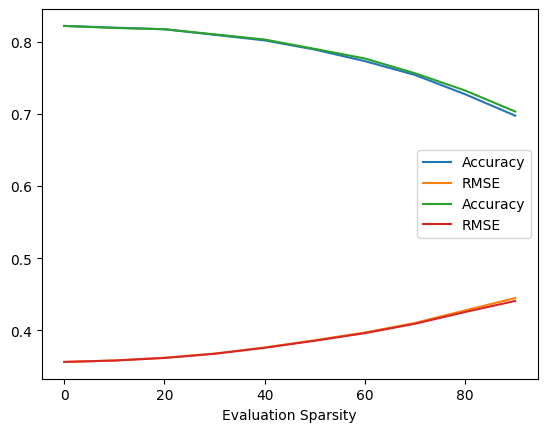

In [6]:
compareTasks(folder_name, data_name, 'Overall')

In [7]:
p = 0
q = 90

predictions = pd.read_csv(f'{method_path}/MF/test_predictions_{p}_{q}.csv', index_col=0)
results = compute_metric(predictions, test_reactions[0], test_reactions[q].isna(), silent=False)

 Fit Accuracy: 0.7263982899893124
 Fit RMSE: 0.43219520296465924
 Imputation Accuracy: 0.701188205955699
 Imputation RMSE: 0.44158190410566556



In [8]:
p = 90
q = 90

predictions = pd.read_csv(f'{method_path}/MF/test_predictions_{p}_{q}.csv', index_col=0)
results = compute_metric(predictions, test_reactions[0], test_reactions[q].isna(), silent=False)

 Fit Accuracy: 0.7267545422158889
 Fit RMSE: 0.43519329228826725
 Imputation Accuracy: 0.6948070998973155
 Imputation RMSE: 0.44574892055905824



In [11]:
p = 90
q = 90

with open(f'{method_path}/PCA_{p}.pkl', 'rb') as file:
    pca = pickle.load(file)

test_data  = prep.impute_dataframe(test_reactions[q], mean=train_reactions[p].mean())

Y = pd.DataFrame(pca.transform(test_data), 
                index=test_reactions[q].index, columns=['x','y'])

test_predictions  = pd.DataFrame(pca.inverse_transform(Y.values),
                                index=test_reactions[q].index, columns=test_reactions[q].columns)

results = compute_metric(test_predictions, test_reactions[0], test_reactions[q].isna(), silent=False)

 Fit Accuracy: 0.7267545422158889
 Fit RMSE: 0.43519329228826725
 Imputation Accuracy: 0.6948070998973155
 Imputation RMSE: 0.44574892055905824

